# Preproccessing and Colaborative Filtering

In [2]:
!wget http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
!pip install surprise
!unzip /content/BX-CSV-Dump.zip

--2021-02-03 19:12:10--  http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
Resolving www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)... 132.230.105.133
Connecting to www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)|132.230.105.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘BX-CSV-Dump.zip.1’

BX-CSV-Dump.zip.1   100%[===================>]  24.88M  13.5MB/s    in 1.8s    

2021-02-03 19:12:13 (13.5 MB/s) - ‘BX-CSV-Dump.zip.1’ saved [26085508/26085508]

Archive:  /content/BX-CSV-Dump.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace BX-Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace BX-Users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


**ایمپورت کردن کتابخانه های لازم**

کتابخانه اصلی برای انجام فرآیندهای مربوط به سیستم پیشنهاد دهنده که استفاده کرده ایم، کتابخانه سورپرایز است.



In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import ascii_letters, digits
from surprise.model_selection import cross_validate
import seaborn as snns
from surprise import Dataset, Reader
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from operator import attrgetter
from sklearn.metrics import mean_squared_error
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle 
import seaborn as sns


**توابع موردنیاز**

در این قسمت توابع کمکی برای انجام امور مربوط به آماده سازی و آموزش مدل سیستم پیشنهاد دهنده وجود دارد.

توضیح عملکرد هر تابع خارج از حوصله این تمرین است.

In [136]:

def k_from_details(details):
    try:
        return details['actual_k']
    except KeyError:
        return 1000

def short_title(title, max_len=40):
    title = str(title).split(' ')
    short_title = ''

    for i in range(len(title)):
        if len(short_title) < max_len:
            short_title = ' '.join([short_title, title[i]])
    short_title = short_title.strip()
    return short_title

def ascii_check(item):
    for letter in str(item):
        if letter not in ascii_letters + digits:
            return 1
        else:
            return 0

def ascii_check_bulk(df):
    for col in df.columns:
        print('items with non-ascii characters in %s: %d' % (col, df[col].apply(ascii_check).sum()))
    print('')

def colname_fix(colname):
    return colname.lower().replace('-','_')


def df_dist(df, colname, norm=False):
    new_df = df[colname].value_counts(normalize=norm).reset_index()
    new_df.columns = [colname, 'count']
    return new_df

def books_groupby(df, column, new_colname):
    df_groupby = df.groupby(column).agg({'isbn': 'count', 'book_rating': 'mean'}).reset_index()
    df_groupby.columns = [new_colname, 'count', 'avg_rating']
    return df_groupby


def draw_distribution(data, title_part, threshold=20):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    sns.distplot(data['count'], color='#2f6194', ax=ax1)
    ax1.set_title('Distribution of number of ratings per %s' % title_part)

    sns.countplot(data[data['count']<=threshold]['count'], color='#2f6194', ax=ax2)
    ax2.set_title('Distribution of number of ratings per %s (<= %d ratings)' % (title_part, threshold))

    plt.show()

def draw_top_chart(data, x, y_list, title):
    fig, ax1 = plt.subplots(figsize=(14, 6))
    plt.xticks(rotation=90)

    palette = sns.color_palette("RdBu", len(data))

    sns.barplot(x=x, y=y_list[0], data=data, palette=palette, ax=ax1)
    ax1.set_title(title)

    ax2 = ax1.twinx()
    sns.scatterplot(x=x, y=y_list[1], data=data, color='black', ax=ax2)

    plt.show()


def get_model_name(model):
    return str(model).split('.')[-1].split(' ')[0].replace("'>", "")

def cv_multiple_models(data, models_dict, cv=3):
    results = pd.DataFrame()

    for model_name, model in models_dict.items():
        print('\n---> CV for %s...' % model_name)

        cv_results = cross_validate(model, data, cv=cv)
        tmp = pd.DataFrame(cv_results).mean()
        tmp['model'] = model_name
        results = results.append(tmp, ignore_index=True)

    return results

def generate_models_dict(models, sim_names, user_based):
    models_dict = {}

    for sim_name in sim_names:
        sim_dict = {
            'name': sim_name,
            'user_based': user_based
        }
        for model in models:
            model_name = get_model_name(model) + ' ' + sim_name
            models_dict[model_name] = model(sim_options=sim_dict)

    return models_dict

def draw_model_results(results):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=90)

    palette = sns.color_palette("RdBu", len(results))

    sns.barplot(x='model', y='test_rmse', data=results, palette=palette, ax=ax1)
    ax1.set_title('Test RMSE and fit time of evaluated models')

    ax2 = ax1.twinx()
    sns.scatterplot(x='model', y='fit_time', data=results, color='black', ax=ax2)
    ax2.set(ylim=(0, results['fit_time'].max() * 1.1))

    plt.show()

ساخت دیتافریم های موردنیاز از دیتاست ها

In [137]:
path = '/content/'

df_ratings = pd.read_csv(path + 'BX-Book-Ratings.csv', sep=';', encoding='cp1250')
df_books = pd.read_csv(path + 'BX-Books.csv', sep=';', encoding='cp1250', escapechar='\\')
df_users = pd.read_csv(path + 'BX-Users.csv', sep=';', encoding='cp1250')

for df in [df_ratings, df_books, df_users]:
    df.columns = [colname_fix(col) for col in df.columns]

در این بخش بررسی می کنیم که آیا متون موجود در دیتاست هایمان شامل کاراکترهای غیراسکی هستند یا خیر.

In [138]:
ascii_check_bulk(df_ratings)
ascii_check_bulk(df_books)
ascii_check_bulk(df_users)

items with non-ascii characters in user_id: 0
items with non-ascii characters in isbn: 55
items with non-ascii characters in book_rating: 0

items with non-ascii characters in isbn: 0
items with non-ascii characters in book_title: 365
items with non-ascii characters in book_author: 21
items with non-ascii characters in year_of_publication: 0
items with non-ascii characters in publisher: 33
items with non-ascii characters in image_url_s: 0
items with non-ascii characters in image_url_m: 0
items with non-ascii characters in image_url_l: 0

items with non-ascii characters in user_id: 0
items with non-ascii characters in location: 560
items with non-ascii characters in age: 0



به دلیل وجود کاراکترهای نان اسکی در برخی از ردیف ها، نیاز است تا قبل از پردازش بر روی داده ها، آن ها را پالایش کرده و حذف نمود.

در این قسمت با استفاده از تابع اسکی-چک، ردیفه هایی که شامل کاراکترهای غیر اسکی می باشد را حذف می کنیم.

In [139]:
df_ratings['isbn_check'] = df_ratings['isbn'].apply(ascii_check)
df_ratings = df_ratings[df_ratings['isbn_check']==0]

df_users['country'] = df_users['location'].apply(lambda x: x.split(', ')[-1].title())
df_users['country_check'] = df_users['country'].apply(ascii_check)
df_users.loc[df_users['country_check']==1, 'country'] = np.nan



حذف کردن ستون های غیرضروری مثل یو آر ال عکس ها و غیره

In [140]:

df_ratings.drop(['isbn_check'], axis=1, inplace=True)
df_books.drop(['image_url_s', 'image_url_m', 'image_url_l'], axis=1, inplace=True)
df_users.drop(['country_check'], axis=1, inplace=True)


در این قسمت دیتاست ریت کتاب ها را به دو بخش تقسیم می کنیم. کتاب هایی که هیچ ریتی دریافت نکردند و کتاب هایی که حداقل یک ریت دریافت کرده اند.

سپس این دو دیتاست را در فایل هایی جداگانه ذخیره می کنیم.

In [141]:
df_ratings_explicit = df_ratings[df_ratings['book_rating']!=0]
df_ratings_implicit = df_ratings[df_ratings['book_rating']==0]

print('Explicit ratings: %d\nImplicit ratings: %d' % (len(df_ratings_explicit), len(df_ratings_implicit)))

path = '/content/'
df_ratings_explicit.to_csv(path + r'data\ratings_explicit.csv', encoding='utf-8', index=False)
df_ratings_implicit.to_csv(path + r'data\ratings_implicit.csv', encoding='utf-8', index=False)
df_books.to_csv(path + r'data\books.csv', encoding='utf-8', index=False)
df_users.to_csv(path + r'data\users.csv', encoding='utf-8', index=False)

Explicit ratings: 433642
Implicit ratings: 716083


به دلیل وجود تعداد زیاد کاربران، کتاب ها و رای کاربران به کتاب ها، درصورتی که قصد داشته باشیم از تمام داده ها استفاده کنیم، فضایی بیش از 500 گیگابایت حافظه رم نیاز خواهد بود.

برای به دست آوردن یک دید کلی از توزیع کتاب ها، رای ها و کاربران رای دهنده، نمودارهای زیر را به دست می آوریم.

همانطور که مشاهده می شود، تعداد نسبتا زیادی از کاربران، فعالیت کمی داشته و حداکثر به یک یا دو کتاب رای داده اند.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


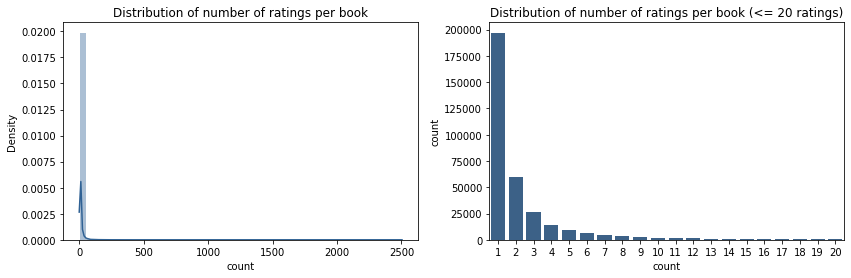

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


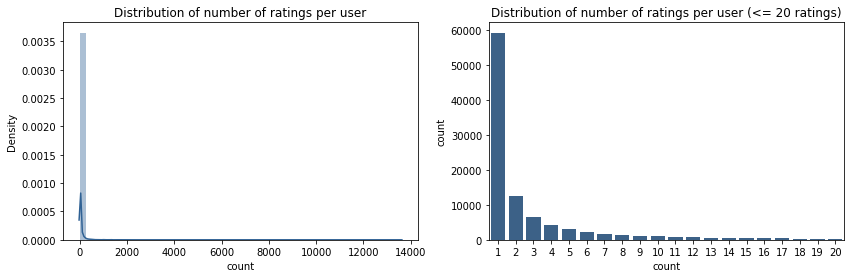

In [145]:
dist_user = df_dist(df_ratings, 'user_id')
dist_book = df_dist(df_ratings, 'isbn')

draw_distribution(dist_book, 'book')
draw_distribution(dist_user, 'user')

در این قسمت دیتاست را از نظر تعداد داده ها، به شکلی مناسب و منطقی کوچک می کنیم.

در مرحله اول به سراغ بخش کاربران کم فعالیت می رویم.

کاربرانی که از بین هزاران کتاب موجود در سیستم، به کمتر از 20 کتاب رای داده اند، کاربران کم فعالیت بوده و اطلاعات با ارزشی به همراه نخواهند داشت.

بنابراین می توانیم این دسته از کاربران را بدون نگرانی از ایجاد خطا در سیستم پیشنهاد دهنده ما، حذف کنیم.


In [13]:
user_ratings_threshold = 20

filter_users = df_ratings_explicit['user_id'].value_counts()
filter_users_list = filter_users[filter_users >= user_ratings_threshold].index.to_list()

df_ratings_top = df_ratings_explicit[df_ratings_explicit['user_id'].isin(filter_users_list)]

print('Filter: users with at least %d ratings\nNumber of records: %d' % (user_ratings_threshold, len(df_ratings_top)))



Filter: users with at least 20 ratings
Number of records: 246791


در این بخش قصد داریم از بین کتاب های موجود در دیتاست، آن هایی که بیشترین تعداد رای را از کاربران فیلتر شده در قسمت قبل گرفته اند  نگه داریم.

بنابراین از لیستی که نشان دهنده تعداد رای هر کتاب است، 10 درصد بالا را انتخاب می کنیم.



In [14]:
book_ratings_threshold_perc = 0.1
book_ratings_threshold = len(df_ratings_top['isbn'].unique()) * book_ratings_threshold_perc

filter_books_list = df_ratings_top['isbn'].value_counts().head(int(book_ratings_threshold)).index.to_list()
df_ratings_top = df_ratings_top[df_ratings_top['isbn'].isin(filter_books_list)]

print('Filter: top %d%% most frequently rated books\nNumber of records: %d' % (book_ratings_threshold_perc*100, len(df_ratings_top)))



Filter: top 10% most frequently rated books
Number of records: 104449


حال داده های موردنیاز و پالایش شده مان را در فایلی ذخیره می کنیم.

In [15]:
df_ratings_top.to_csv(path + r'data\ratings_top.csv', encoding='utf-8', index=False)

در این قسمت با استفاده از کتابخانه سورپرایز، دیتاستی که در قسمت قبل آماده کردیم لود می کنیم.

In [16]:
df = pd.read_csv(path + r'data\ratings_top.csv')

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'isbn', 'book_rating']], reader)

برای پیاده سازی این قسمت از مدل کی ان ان استفاده می کنیم.

برای اینکه بتوانیم بهترین مدل کی ان ان را انتخاب کنیم، در ابتدا خطای هرکدام را با معیار ام اس ادی محاسبه می کنیم.

مدلی که کمترین خطا را داشته باشد، برای ادامه مراحل انتخاب می کنیم.

In [17]:
models1 = generate_models_dict([KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline], ['msd'], True)
results1 = cv_multiple_models(data, models1)
models1 = None
display(results1)


---> CV for KNNBasic msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithMeans msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithZScore msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNBaseline msd...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimat

,fit_time,model,test_mae,test_rmse,test_time
0,0.636197,KNNBasic msd,1.475850,1.936532,1.176711
1,0.600294,KNNWithMeans msd,1.294239,1.731066,1.145690
2,0.712848,KNNWithZScore msd,1.275450,1.726482,1.102417
3,0.819106,KNNBaseline msd,1.316514,1.743742,1.252419


بنابر خروجی قسمت بالا، کمترین خطا مربوط به سومی است.

پس از این مدل در ادامه مراحل استفاده خواهیم کرد.

NameError: ignored

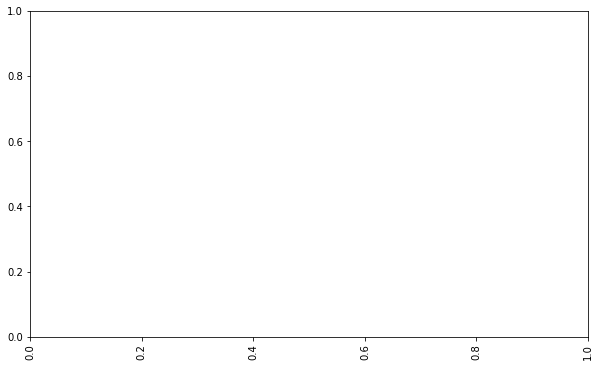

In [18]:
draw_model_results(results1)

مدل ما باید با استفاده از مجموعه ای از پارامترهای مختلف مثل حداقل تعداد همسایه ها، تعداد ایپوک ها وغیره آموزش ببیند.

به دست آوردن مقدار بهینه برای این پارامترها را با استفاده از کلاس گریدسرچ انجام می دهیم.

ورودی تابع زیر نام الگوریتم شباهت سنجی و متغیری برای مشخص کردن یوزریوزر یا آیتم آیتم بودن مدل.

خروجی تابع نیز اطلاعاتی شامل میزان خطای مدل به ازای پارامترهای مختلف است.

In [19]:
 
def get_best_param(name, user_based):
    param_grid = {'k': [40,45,50],
                  'min_k': [1,3,5],
                  'sim_options': {'name': [name],
                                  'min_support': [1, 5],
                                  'user_based': [user_based]}
                  }
    gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    
    return gs


در هرکدام از 4 سلول زیر، پارامترهای بهینه برای مدل مان را برای حالت یوزیوزر و آیتم آیتم و بر اساس محاسبه کسینوسی و پیرسون و با استفاده از کلاس گریدسرچ، می یابیم.

به دلیل زمان بر بودن این فرآیند، بعد از پیدا شدن پارامترهای بهینه، خروجی را برای استفاده در آینده در فایل ذخیره می کنیم.

In [20]:
# user_cosine = get_best_param('cosine', True)

# f = open('user_cosine', 'wb') 
# pickle.dump(user_cosine, f)
f = open('user_cosine', 'rb') 
user_cosine = pickle.load(f)
user_cosine

In [21]:
# user_pearson = get_best_param('pearson',False)

# f = open('user_pearson', 'wb') 
# pickle.dump(user_pearson, f)
f = open('user_pearson', 'rb') 
user_pearson = pickle.load(f)
user_pearson

In [22]:
# item_cosine = get_best_param('cosine', True)

# f = open('item_cosine', 'wb') 
# pickle.dump(item_cosine, f)
f = open('item_cosine', 'rb') 
item_cosine = pickle.load(f)
item_cosine

In [23]:
# item_pearson = get_best_param('pearson', False)

# f = open('item_pearson', 'wb') 
# pickle.dump(item_pearson, f)
f = open('item_pearson', 'rb') 
item_pearson = pickle.load(f)
item_pearson

همانطور که در خروجی سلول پایین مشاهده می شود، دقت مدل ما در حالتی که شباهت سنجی فلان و الگوریتم بهمان بهمان باشد، از بقیه حالات بهتر است.

بنابراین در ادامه مراحل  از این پارامترها استفاده  خواهیم کرد.

// TODO find best

In [24]:
print('RMSE of Item-Item - pearson: ', item_pearson.best_score['rmse'], 'with this params: ', item_pearson.best_params['rmse'])
print('RMSE of Item-Item - cosine: ',item_cosine.best_score['rmse'], 'with this params: ', item_cosine.best_params['rmse'])
print('RMSE of User-User - pearson: ',user_pearson.best_score['rmse'], 'with this params: ', user_pearson.best_params['rmse'])
print('RMSE of User-User - cosine: ',user_cosine.best_score['rmse'], 'with this params: ', user_cosine.best_params['rmse'])


RMSE of Item-Item - pearson:  1.8539212478380935 with this params:  {'k': 45, 'min_k': 3, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}}
RMSE of Item-Item - cosine:  1.5729754118456256 with this params:  {'k': 50, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_support': 1, 'user_based': True}}
RMSE of User-User - pearson:  1.8462691793484278 with this params:  {'k': 40, 'min_k': 3, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}}
RMSE of User-User - cosine:  1.5718790364443513 with this params:  {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_support': 1, 'user_based': True}}


In [25]:
model = generate_models_dict([KNNBaseline], ['cosine'], False)
result = cv_multiple_models(data, model)
model = None
display(result)



---> CV for KNNBaseline cosine...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


,fit_time,model,test_mae,test_rmse,test_time
0,16.029775,KNNBaseline cosine,1.213545,1.634254,4.297146


قبل از دادن دیتاست به مدل جهت آموزش، نیاز داریم تا داده ها را به دو قسمت تست و ترین تقسیم کنیم.

برای این کار، 20 درصد داده ها را برای تست و 80 درصد را برای ترین شدن مدل درنظر می گیریم.

این کار را با استفاده از کتابخانه اس کالرن انجام می دهیم. نحوه جداسازی داده های تست و ترین به صورت رندوم می باشد.

In [26]:
trainset, testset = train_test_split(data, test_size=0.2)

با استفاده از مقادیر بهینه پارامترها که در بخش قبلی و با استفاده از کلاس گریدسرچ به دست آوردیم، مدل مان را ساخته و فرآیند آموزش را روی داده های ترین انجام می دهیم.

In [27]:

sim_options = {
    'name': 'cosine',
    'user_based': False,
    'min_support': 1
}

model = KNNBaseline(k=45, min_k=5, sim_options=sim_options)
model.fit(trainset)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


حال نیاز داریم تا دقت مدل مان را محاسبه کنیم.

برای اینکار مجموعه تست مان را به مدل می دهیم تا ریت کاربران را تخمین بزند. 

خروجی تخمین مدل را در متغیر پردیکشنز ذخیره می کنیم.

In [28]:
predictions = model.test(testset)

حال که ریت واقعی کاربران و ریت تخمینی مدل مان را داریم، خطای مدل را محاسبه می کنیم.

برای اینکار از معیار های ام اس ای و آر ام اس ای استفاده می کنیم.

In [29]:
# Calculate RMSE and mse
estimates = list(map(attrgetter('est'), predictions))
actuals = [i[2] for i in testset]

mse = mean_squared_error(actuals, estimates)
rmse = math.sqrt(mse)

print('MSE:', mse)
print('RMSE', rmse)


MSE: 2.3167340958733695
RMSE 1.522082158056315


در این بخش خروجی تخمین مدل مان را به یک دیتافریم تبدیل می کنیم تا تعامل با دیتاهای آن راحت تر شود.

In [30]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'pred_rating', 'details'])

df_pred['k'] = df_pred['details'].apply(k_from_details)
df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)

df_pred.sample(5)

,user_id,isbn,actual_rating,pred_rating,k,impossible,pred_rating_round,abs_err
14376,138602,0812513711,10.0,9.673954,9,False,10.0,0.326046
1399,8454,0452281784,7.0,8.027026,16,False,8.0,1.027026
20275,6575,0743227441,7.0,7.739446,45,False,8.0,0.739446
9789,204864,0671024809,7.0,8.603794,4,False,9.0,1.603794
2929,154176,0425097722,5.0,7.889724,0,False,8.0,2.889724


در این قسمت دقت مدل را با به دست آوردن تخمین های درست بر کل به دست می آوریم.

دقت درست در این بخش یعنی تخمین هایی که مدل مان با اختلاف 1.5 واحد به دست آورده است.

مثلا اگر ریت واقعی کاربر 4 بوده، تخمین درست تخمینی در بازه 2.5 تا 5.5 خواهد بود.

In [31]:
t = len(df_pred[abs(df_pred['actual_rating'] - df_pred['pred_rating']) <= 1.5])
print("Accuracy:", t / len(df_pred) * 100)



Accuracy: 71.34992819530876


در این قسمت باید تابعی برای ارائه پیشنهادات مناسب به کاربر بنویسیم.

در تابع زیر با استفاده از مدلی که آموزش دادیم، با دریافت یک یوزرآی دی، کتاب هایی که تخمین می زنیم کاربر امتیاز بالایی به آنها بدهد را به او پیشنهاد می دهیم.

In [33]:
def recommend_topN(user_id, df_books, n):
  df_books = df_books[['isbn']]

  df_books.insert(loc=0, column='user_id', value=user_id)
  df_books.insert(loc=2, column='rating', value=0)

  user_books = list(df_books.itertuples(index=False, name=None))

  pred = model.test(user_books)
  pred.sort(key=lambda x: x.est, reverse=True)
  return pred[0:n]
  

user_id = 32440
n = 5
recomended_books = recommend_topN(user_id, df_books, n)
recomended_books

[Prediction(uid=32440, iid='0618002235', r_ui=0, est=9.285007204498964, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid=32440, iid='0743454529', r_ui=0, est=9.199277051981488, details={'actual_k': 16, 'was_impossible': False}),
 Prediction(uid=32440, iid='0811824829', r_ui=0, est=9.19304905684319, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=32440, iid='0345339738', r_ui=0, est=9.026743028314499, details={'actual_k': 12, 'was_impossible': False}),
 Prediction(uid=32440, iid='0679732764', r_ui=0, est=9.024090184771717, details={'actual_k': 6, 'was_impossible': False})]

# Content base

در این قسمت  قصد داریم تا به صورت کانتنت بیس و با استفاده از عنوان کتاب ها، مناسب ترین کتاب را به کاربر پیشنهاد بدهیم.

In [34]:
ratings_df = pd.read_csv(r'/content/data\ratings_top.csv')
ratings_df

,user_id,isbn,book_rating
0,276847,3404148576,8
1,276847,3423071516,10
2,276847,3426029553,8
3,276847,3442437717,7
4,276847,3442441080,10
...,...,...,...
104444,276688,0688156134,8
104445,276688,0743202694,10
104446,276688,0836218655,10
104447,276688,0836236688,10


In [35]:
books_df = pd.read_csv(r'/content/data\books.csv')
books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


در این قسمت کتاب هایی که حداقل یک کاربر به آنها رای داده اند را به دست می آوریم.

In [36]:
all_books = ratings_df['isbn'].unique()
books_df = books_df[books_df['isbn'].isin(all_books)]
books_df.head(5)

,isbn,book_title,book_author,year_of_publication,publisher
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
18,0440234743,The Testament,John Grisham,1999,Dell
19,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume
20,0609804618,Our Dumb Century: The Onion Presents 100 Years...,The Onion,1999,Three Rivers Press


با استفاده از کتابخانه اس کا لرن و کلاس تی اف وکتورایز، عناوین کتاب ها را پردازش کرده و ماتریس تی اف آی دی اف را محاسبه می .کنیم

In [37]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(books_df['book_title'])

حال شباهت کسینوسی را بر اساس ماتریس به دست آمده از بخش قبل محاسبه می کنیم.

با این کار میزان شباهت هر کتاب نسبت به کتاب های دیگر را خواهیم داشت.

In [38]:
cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)


به دلیل به هم ریختگی ترتیب ایندکس ها، آن را ریست می کنیم تا شمارش از 1 و به صورت مرتب شود.

In [39]:
books_df.reset_index(drop=True, inplace=True)
books_df[books_df['book_title'].str.contains("Dummie")]

,isbn,book_title,book_author,year_of_publication,publisher
3736,1568846444,Gardening for Dummies,Michael MacCaskey,1996,John Wiley &amp; Sons
4256,0836220498,Night Of Crash-Test Dummies,Gary Larson,1988,Andrews McMeel Publishing
4480,076455168X,Weight Training for Dummies,Liz Neporent,2000,For Dummies
4987,0764550039,Chess for Dummies,James Eade,1996,For Dummies
11766,0764551302,Gardening for Dummies,Mike MacCaskey,1999,For Dummies
12089,0764503545,"The Internet for Dummies, Fifth Edition",John R. Levine,1998,John Wiley &amp; Sons Inc


در این قسمت حلقه ای برای پیمایش روی کتاب ها داریم.

در هر پیمایش و به ازای هر کتاب، با استفاده از شباهت کسینوسی کتاب ها که در بخش قبل به دست آوردیم، تمام کتاب های مشابه به ازای هر کتاب را به دست آورده و بر اساس شباهت مرتب شان می کنیم.

از لیست به دست آمده، آی اس بی ان 5 کتاب اول که بیشترین شباهت را به کتاب مورد پیمایش دارند را به دست می آوریم.

در ادامه و با استفاده از این آی اس بی ان ها، اطلاعات این کتاب ها را به دست آورده و در لیست ریزالت ذخیره می کنیم.

بنابراین در لیست ریزالت، به ازای هر کتاب، 5 کتابی که بیشترین شباهت را به آن دارند، ذخیره کردیم.

In [40]:
num = 12
results = {}
for idx, row in books_df.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-2-num:-1]
    similar_items = [(cosine_similarities[idx][i], books_df['isbn'][i]) for i in similar_indices]
    results[row['isbn']] = similar_items[1:]

در این تابع با دریافت آی اس بی ان یک کتاب، اطلاعات آن را به عنوان خروجی برمی گردانیم.

In [41]:
def item(id):
    return books_df.loc[books_df['isbn'] == id]['book_title'].tolist()[0]

در این بخش با دریافت آی اس بی ان یک کتاب، به تعداد عدد ورودی، مشابه ترین کتاب ها را پیشنهاد می کنیم.
با سورت نتیجه مشابهت کسینوسی، مشابه ترین کتاب ها با کتاب مورد نظر را پیدا می کنیم


In [42]:
def recommend(id, num, pr = True):
  if (num == 0):
      if pr:
        print("Unable to recommend any book as you have not chosen the number of book to be recommended")
  elif (num==1):
    if pr:
      print("Recommending " + str(num) + " book similar to " + item(id))
  else :
    if pr:
      print("Recommending " + str(num) + " books similar to " + item(id))
  if pr: 
    print("----------------------------------------------------------")

  # پیدا کردن نزدیک ترین کتاب ها به کتاب مورد نظر
  recs = results[id][:num]
  for rec in recs:
    if pr:
      print("You may also like to read: " + item(rec[1]) + " (score:" + str(rec[0]) + ")")
  return recs

در این قسمت برای کتابی با آی اس بی ان 0373765738، 5 کتاب مشابه را پیشنهاد می دهیم.

In [43]:
book_res = recommend('1568846444',num)

Recommending 12 books similar to Gardening for Dummies
----------------------------------------------------------
You may also like to read: Gardening for Dummies (score:1.0000000000000004)
You may also like to read: Chess for Dummies (score:0.2972322667224442)
You may also like to read: Weight Training for Dummies (score:0.2128792202588689)
You may also like to read: Square Foot Gardening (score:0.21053923529126084)
You may also like to read: Night Of Crash-Test Dummies (score:0.17801895749981303)
You may also like to read: The Internet for Dummies, Fifth Edition (score:0.17599907376127127)
You may also like to read: Rodale's Successful Organic Gardening: Perennials (Rodale's successful organic gardening) (score:0.15382152564171667)
You may also like to read: Llewellyn's 2001 Moon Sign Book and Gardening Almanac (score:0.12510516191093993)
You may also like to read: Taylor's Guide to Roses (Taylor's Guides to Gardening) (score:0.12319028791401043)
You may also like to read: Death Matc

در این تابع با دریافت یک یوزرآی دی، ابتدا کتاب هایی که این کاربر به آنها رای داده است را پیدا می کنیم.

سپس این لیست را بر اساس میزان رای کاربر مرتب می کنیم.

حال 4 کتابی که بیشترین رای را از کاربر گرفته را جدا می کنیم.

در ادامه به ازای هر کدام از این 4 کتاب، 4 کتابی که از نظر شباهت عناوین بیشترین شباهت را به آنها دارد به لیست پیشنهادی اضافه کرده و آن را به عنوان نتیجه بر میگردانیم.

In [113]:
def recommend_base_on_user(user_id, n, ratings_df = ratings_df, pr=False):
    u_ratings = ratings_df[ratings_df['user_id']==user_id]
    most_freq_books = u_ratings.sort_values(by=['book_rating']).isbn[:int(math.sqrt(n))]
    recommends = []
    for freq_book in most_freq_books:
        recommends.extend(recommend(freq_book,int(math.sqrt(n)), pr))
    return recommends

مثلا در این قسمت ، برای کاربری با یوزرآی دی 60419، 10 کتاب پیشنهاد می دهیم.

In [114]:
user_res = recommend_base_on_user(60419, 10)
# user_res

# حالت ترکیبی
در این قسمت قصد داریم تا سیستم پیشنهاد دهنده کولبریتیوفیلترینگ مان را با بخش کانتنت بیس ادغام کنیم.

برای اینکار ابتدا از سیستم کانتنت بیس مان مجموعه ای از کتاب ها برای یک کاربر خاص دریافت می کنیم.

حال این لیست را به همراه یوزر آی دی عنوان ورودی به سیستم کولبریتیوفیترینگ مان می دهیم.

بنابراین سیستم پیشنهاد دهنده مبتنی بر کولبریتینگ فیلترینگ مان از بین لیست کتاب های آمده از بخش کانتنت بیس و بر اساس کاربر ورودی، تخمین میزند که این کاربر به هر کدام از این کتاب ها چه امتیازی می دهد و بعد از آن، بالاترین آن ها را به عنوان خروجی برمی گرداند.

In [104]:
def hybrid_recommend(user_id, n,ratings_df = ratings_df, pr=True):
  content_base_result = recommend_base_on_user(user_id, n*5,ratings_df , pr)
  content_base_result_df = pd.DataFrame(content_base_result, columns=['similarity', 'isbn'])

  colab_filt_result = recommend_topN(user_id, content_base_result_df, n)
  return colab_filt_result

hybrid_recommend(60419, 10)

       user_id        isbn  book_rating
24492    60419  0156838389           10
24493    60419  0226469409           10
24494    60419  0394740181           10
24495    60419  0679727590           10
24496    60419  1568846444           10
Recommending 7 books similar to Sophocles, The Oedipus Cycle: Oedipus Rex, Oedipus at Colonus, Antigone
----------------------------------------------------------
You may also like to read: Casual Rex: A Novel (score:0.0756105358468622)
You may also like to read: Spin Cycle (score:0.07546851593875303)
You may also like to read: Cycle Of The Werewolf (score:0.07345641132822019)
You may also like to read: Antigone (Dover Thrift Editions) (score:0.07093626499005683)
You may also like to read: Antigone (French Language Edition) (score:0.062457838009252704)
You may also like to read: Anonymous Rex: A Detective Story (score:0.06072974944794644)
You may also like to read: Taliesin : Book One of the Pendragon Cycle (Pendragon Cycle) (score:0.0575038402666502

[Prediction(uid=60419, iid='0836220498', r_ui=0, est=8.756370742153088, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=60419, iid='0140275363', r_ui=0, est=8.68230165874759, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=60419, iid='0878573410', r_ui=0, est=8.625146624435809, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=60419, iid='0486278042', r_ui=0, est=8.532464502684407, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=60419, iid='0394748646', r_ui=0, est=8.515312479308946, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=60419, iid='1882413601', r_ui=0, est=8.439966203872384, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=60419, iid='0812544501', r_ui=0, est=8.432371447381893, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=60419, iid='0553257382', r_ui=0, est=8.38969237682841, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=60

# ارزیابی

در این بخش سه روش پالایش همکارانه، روش مبتنی بر محتوا و حالت ترکیب این دو روش را مقایسه می کنیم.

ابتدا کاربرانی که حداقل ۱۰۰ امتیاز در مجموعه تست دارند را جدا می کنیم. تا اطلاعات کافی برای شبیه سازی اطلاعات زمان آینده که آن کاربر امتیازی برای آن کتاب ثبت کرده استُ داشته باشیم.

In [48]:
testset_df = pd.DataFrame(testset, columns=['user_id', 'isbn', 'actual_rate'])

rate_counts = testset_df['user_id'].value_counts()
filter_rate_counts = rate_counts[rate_counts >= 100].index.to_list()

testset_df = testset_df[testset_df['user_id'].isin(filter_rate_counts)]
testset_df.reset_index(drop=True, inplace=True)


In [49]:
users_of_testset = testset_df['user_id'].to_list()

In [96]:
test_books = df_books[df_books['isbn'].isin(testset_df['isbn'])]
test_set_renamed = testset_df.rename(columns={'actual_rate': 'book_rating'})

در تابع ارزیابی با توجه به روش داده  شده در آرگومان تابع مشخص می کنیم که از کدام روش پیشنهاد دهی استفاده کنیم.

سپس بررسی میکنیم که این حدود امتیازی که کاربر به کتاب های مختلف داده است چه مقدار است. 0.4 بالایی آن را محاسبه میکنیم.
اگر کاربر رای بالاتر از این مقدار برای کتابی ثبت کرده باشد به این معنا است که نسبت به کتاب های دیگر ، علاقه بیشتری به این کتاب داشته است.
از همین روش استفاده میکنیم تا تعدا کل کتاب های مورد علاقه کاربر در مجموعه تست را به دست آوریم.
سپس تعداد کتاب های پیشنهادی را محاسبه میکنیم

برای محاسبه فراخوانی تعداد کتاب هایی که پیشنهاد داده ایم و مورد علاقه کاربر هستند را بر تعداد کل پیشنهادات ممکن که در مجموعه تست وجود دارند تقسیم می کنیم.

برای محاسبه دقت تعداد پیشنهادات صحیح سیستم که مورد علاقه کاربر هستند را بر تعداد کل پیشنهاداتی که سیستم داده است و ممکن است صحیح یا غلط باشند، تقسیم میکنیم.

In [128]:
def evaluate(recommendType):
  recalls = []
  precisions = []
  i=0
  usersCount = len(users_of_testset)
  for user in users_of_testset:
    i+=1
    if i%10 == 0:
      print(i/usersCount)
    if recommendType == 1: # colab filter
      recom = recommend_topN(user, test_books, 30)
      recom_df = pd.DataFrame(recom, columns=['user_id', 'isbn', 'r_ui', 'estimate', 'details'])
    elif recommendType == 2: #content base
      recom = recommend_base_on_user(user, 30, test_set_renamed, False)
      recom_df = pd.DataFrame(recom, columns=['user_id','isbn'])
    elif recommendType == 3: # hybrid
      recom = hybrid_recommend(user, 30,test_set_renamed, False)
      recom_df = pd.DataFrame(recom, columns=['user_id', 'isbn', 'r_ui', 'estimate', 'details'])



    quantile_of_user_rates = testset_df[testset_df['user_id'] == user]['actual_rate'].quantile(.6)

    user_books_in_test = testset_df[(testset_df['user_id'] == user) &
                                    (testset_df['isbn'].isin(recom_df['isbn'])) &
                                    (testset_df['actual_rate'] >= quantile_of_user_rates)]
    user_books_in_recom = recom_df[recom_df['isbn'].isin(user_books_in_test['isbn'])]

    del user_books_in_recom['user_id']

    user_books_in_test = user_books_in_test.set_index('isbn')
    user_books_in_recom = user_books_in_recom.set_index('isbn')
    user_books_in_recom = user_books_in_recom.join(user_books_in_test)

    top_rated_user_books = testset_df[(testset_df['user_id'] == user) & (testset_df['actual_rate'] >= quantile_of_user_rates)]

    recall = len(user_books_in_recom) / len(top_rated_user_books)
    precision = len(user_books_in_recom) / len(recom_df)
    
    recalls.append(recall)
    precisions.append(precision)

  # print("recall:", np.mean(recalls))
  # print("precision:",np.mean(precisions))
  return np.mean(recalls), np.mean(precisions)


In [129]:
recall_colab, precision_colab = evaluate(1)
recall_content, precision_content = evaluate(2)
recall_hybrid, precision_hybrid = evaluate(3)

print("collaborative filtering result:  recall=",recall_colab, "precision=" ,precision_colab)
print("content based filtering result:  recall=",recall_content, "precision=" ,precision_content)
print("Hybrid filtering result:  recall=",recall_hybrid, "precision=" ,precision_hybrid)

0.01107419712070875
0.0221483942414175
0.03322259136212625
0.044296788482835
0.05537098560354374
0.0664451827242525
0.07751937984496124
0.08859357696567
0.09966777408637874
0.11074197120708748
0.12181616832779624
0.132890365448505
0.14396456256921372
0.15503875968992248
0.16611295681063123
0.17718715393134
0.18826135105204872
0.19933554817275748
0.21040974529346623
0.22148394241417496
0.23255813953488372
0.24363233665559247
0.2547065337763012
0.26578073089701
0.2768549280177187
0.28792912513842744
0.29900332225913623
0.31007751937984496
0.3211517165005537
0.33222591362126247
0.3433001107419712
0.35437430786268
0.3654485049833887
0.37652270210409744
0.3875968992248062
0.39867109634551495
0.4097452934662237
0.42081949058693247
0.4318936877076412
0.4429678848283499
0.4540420819490587
0.46511627906976744
0.47619047619047616
0.48726467331118495
0.4983388704318937
0.5094130675526024
0.5204872646733112
0.53156146179402
0.5426356589147286
0.5537098560354374
0.5647840531561462
0.575858250276854

همانطور که از نتایج چاپ شده مشخص است، در روش پالایش همکارانه بیشترین دقت و فراخوانی را داشته ایم. پس  به نظر برای این مجموعه داده ، این روش مناسبتر است.